## モジュールのインポート

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.layers import Input, Dense, Layer, BatchNormalization, Dropout, RepeatVector
from keras.layers import Lambda, Conv2D, Flatten, MaxPooling2D
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D, TimeDistributed
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.models import Model, model_from_json
from keras import backend as K
#from keras import objectives
from keras.losses import binary_crossentropy
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf
from keras.backend import tensorflow_backend

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

from scipy.stats import norm
from sklearn.model_selection import train_test_split

from glob import glob
from multiprocessing import Pool
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
from time import time
import datetime
import os
from collections import OrderedDict

Using TensorFlow backend.


In [56]:
plt.style.use("ggplot")

## モデルの読み込み

In [2]:
with open("../output/vid_vae_model_20190106_150419.json") as f:
    json_string = f.readline()

In [3]:
model = model_from_json(json_string)
model.load_weights("../output/vid_vae_best_param_20190106_150419.hdf5")

## データの前処理

In [4]:
!ls ../data/shogi_pose_dataset/

AbemaTV_Tournament_Final1      fujii_vs_kondo_Ablock_2_1_1080p
AbemaTV_Tournament_Final2      fujii_vs_kondo_Ablock_2_2_1080p
AbemaTV_Tournament_Final3      fujii_vs_takami_semi_1_1080p
final1_labeling		       fujii_vs_takami_semi_2_1080p
fujii_vs_kondo_Ablock_1_1080p  fujii_vs_takami_semi_3_1080p


In [5]:
#dirs_path = sorted(glob("../data/shogi_pose_dataset/AbemaTV_Tournament_Final*"))
data_path = sorted(glob("../data/shogi_pose_dataset/final1_labeling/*"))

In [6]:
def read_img(path):
    cv2.setNumThreads(0)
    img = cv2.imread(path, 0)
    idx = int(path[-10:-4])
    size = 32
    
    # openposeのミスをできるだけ前処理で落とす
    try:
        x, w, y, h = trimming(img)
        margin = 16
        img_trim = img[y-margin:h+margin, x-margin:w+margin]
        height, width = img_trim.shape
        
        if (height < 150) or (width < 150):
            return {idx: np.zeros((size, size))}
        
        # 膨張処理
        kernel = np.ones((6,6),np.uint8)
        img_trim = cv2.bitwise_not(img_trim) # 白(255)を膨張させるため反転
        img_dil = cv2.dilate(img_trim,kernel,iterations = 1)
        
        img_dil = cv2.resize(img_dil, (size, size))
        
        # 2値化
        _,img_bin = cv2.threshold(img_dil,0,1,cv2.THRESH_BINARY)
        
        return {idx: img_bin * 255.0}
    except:
        return {idx: np.zeros((size, size))}

In [7]:
def trimming(img):
    mask = img < 255
    x = np.where(np.sum(mask, axis=0) > 1)[0]
    y = np.where(np.sum(mask, axis=1) > 1)[0]
    
    x_min, x_max = x[0], x[-1]
    y_min, y_max = y[0], y[-1]
    return x_min, x_max, y_min, y_max

In [8]:
def read_img(path):
    cv2.setNumThreads(0)
    img = cv2.imread(path, 0)
    idx = int(path[-10:-4])
    return {idx: img * 255.0}

In [9]:
imgs_dict = {}
with tqdm(total=len(data_path)) as pbar:
    with Pool(mp.cpu_count()) as p:
        for img in tqdm(p.imap_unordered(read_img, data_path)):
            imgs_dict.update(img)
            pbar.update()
imgs_dict = OrderedDict(sorted(imgs_dict.items(), key=lambda x: x[0]))

### 画像を5フレームごとに分割
- 5フレーム(0.5秒)のデータを5フレームごとにスライドしてデータを作成する。

In [10]:
imgs = np.array([item[1].astype(np.float32) for item in imgs_dict.items()])
black_idxs = np.where(imgs.mean(axis=(1,2)) == 0)[0]
white_idxs = np.where(imgs.mean(axis=(1,2)) != 0)[0]
imgs /= 255

In [11]:
stride = 5
time = 5

vids = []
for idx in tqdm(range((len(imgs) // 5) - 1)):
    vids.append(np.array(imgs[idx * stride: time + idx * stride]))

In [12]:
vids_num, time, height, width = np.array(vids).shape

vids = np.array(vids).reshape(vids_num, time, height, width, 1) #/ 255

print(vids.shape)

(107, 5, 32, 32, 1)


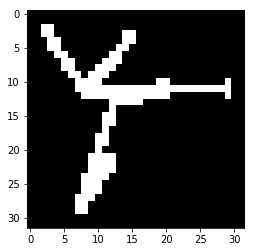

In [13]:
plt.imshow(vids[0][0].reshape(32,32), cmap="gray")

## モデルによる生成

In [18]:
vids_pred = model.predict(vids.astype(np.uint8) * 255)

In [19]:
v_show = vids[5].reshape(5,32,32)
p_show = vids_pred[5].reshape(5,32,32)

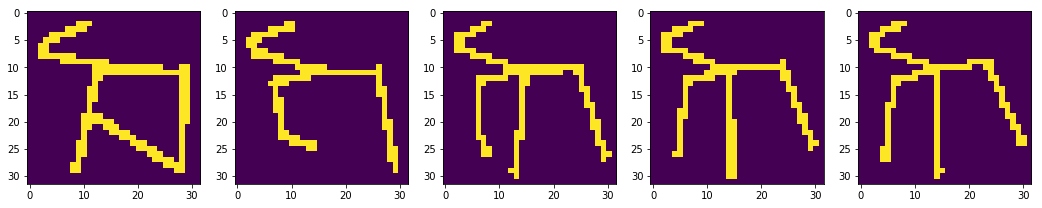

In [20]:
fig, ax = plt.subplots(ncols=5, figsize=(18,10))
for i in range(5):
    ax[i].imshow(v_show[i])
plt.show()

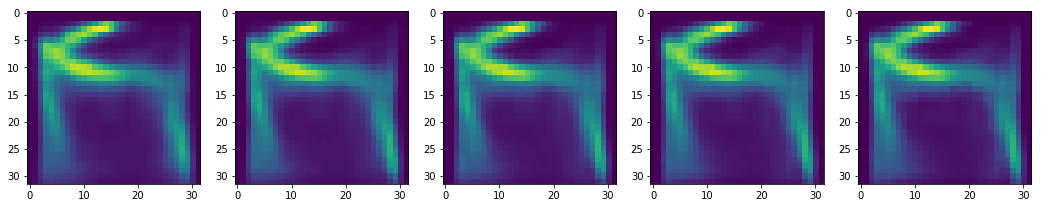

In [21]:
fig, ax = plt.subplots(ncols=5, figsize=(18,10))
for i in range(5):
    ax[i].imshow(p_show[i])
plt.show()

### しきい値を元にした比較

In [22]:
import pandas as pd

In [41]:
np.sum(np.abs(vids[0]), axis=(1,2,3)).shape

(5,)

In [42]:
l = []
for y_true, y_pred in tqdm(zip(vids.astype(np.float32) / 255, vids_pred.astype(np.float32) / 255)):
    y_diff = y_true - y_pred
    l.append(np.sum(np.abs(y_diff), axis=(1,2,3)).mean())
df = pd.DataFrame(l, columns=["pixel_diff"])

In [46]:
scores_df = df

Text(0.5, 0, 'images difference (pixel base)')

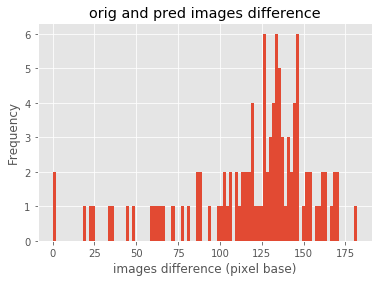

In [57]:
fig, ax = plt.subplots()

ax = scores_df["pixel_diff"].plot.hist(bins=100)
ax.set_title("orig and pred images difference")
ax.set_xlabel("images difference (pixel base)")

### Phashに変換して比較

In [49]:
import imagehash
from PIL import Image

In [101]:
l = []
for y_true, y_pred in tqdm(zip(vids.astype(np.float32), vids_pred.astype(np.float32))):
    l2  = []
    for t, p in zip(y_true, y_pred):
        true_hash = imagehash.phash(Image.fromarray(t.astype(np.uint8).reshape(32,32)))
        pred_hash = imagehash.phash(Image.fromarray((p * 255).astype(np.uint8).reshape(32,32)))
        l2.append(true_hash - pred_hash)
    l.append(round(np.array(l2).mean()))

In [102]:
print(true_hash)

c4d36a2d141e9e8f


In [103]:
print(pred_hash)

e0c34a3d1e9e9e70


In [104]:
_df = pd.DataFrame(l, columns=["phash_diff"])

In [105]:
scores_df["phash_diff"] = _df

Text(0.5, 0, 'images difference (phash base)')

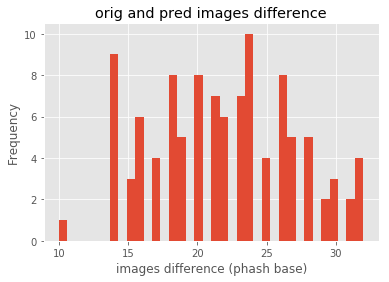

In [107]:
fig, ax = plt.subplots()

ax = scores_df["phash_diff"].plot.hist(bins=36)
ax.set_title("orig and pred images difference")
ax.set_xlabel("images difference (phash base)")

In [108]:
len(sorted(scores_df.phash_diff.value_counts().index))

20

In [110]:
scores_df[scores_df.phash_diff == 15].index[:5]

Int64Index([87, 96, 105], dtype='int64')

In [111]:
vids[0].shape

(5, 32, 32, 1)

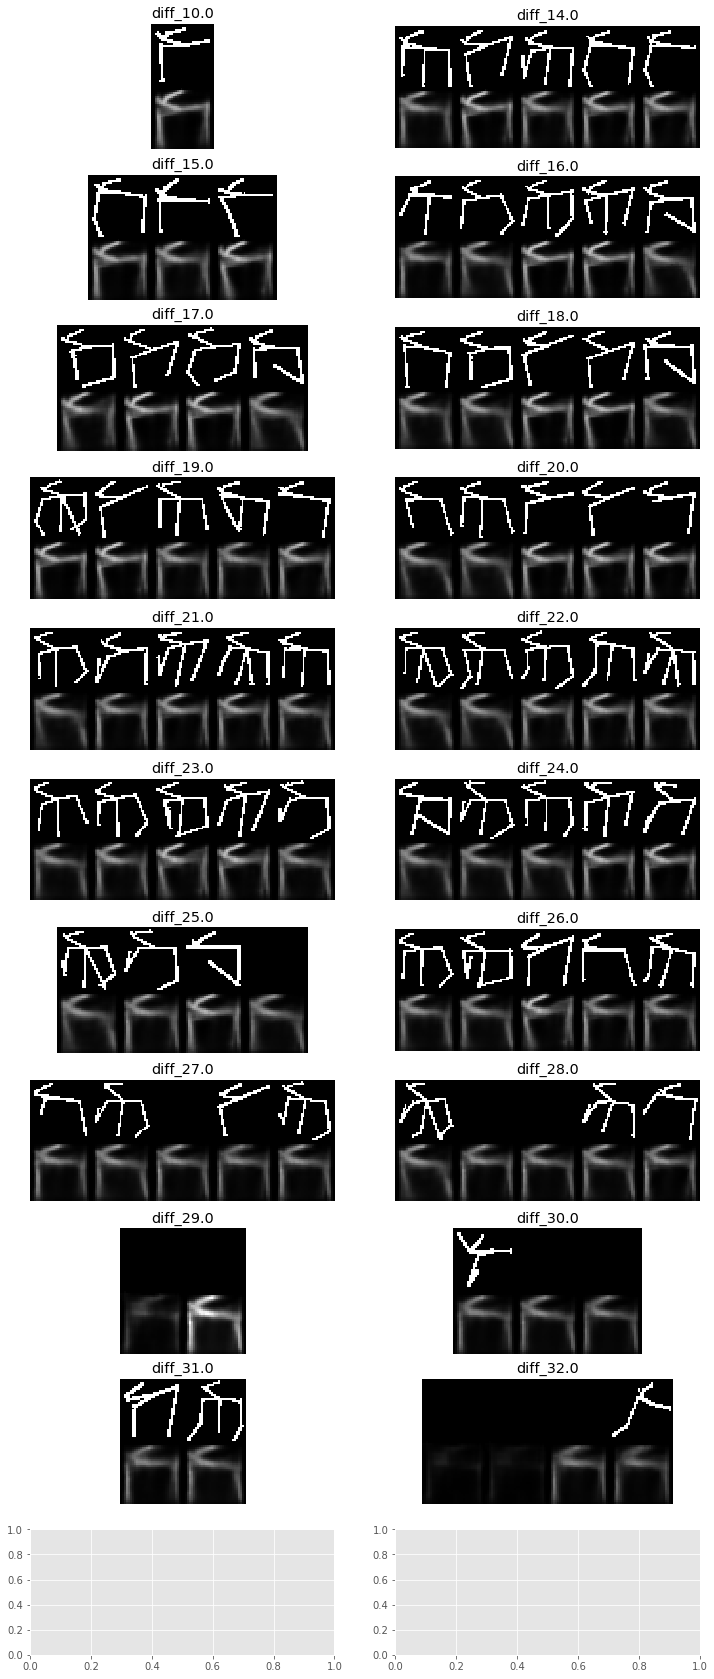

In [114]:
phash_diff = sorted(scores_df.phash_diff.value_counts().index)
fig, ax = plt.subplots(nrows=len(phash_diff)//2 + 1, ncols=2, figsize=(12,30))

compare_vids = []
flag = True
for row, phash in enumerate(phash_diff):
    idxs = scores_df[scores_df.phash_diff == phash].index[:5]
    
    for col, idx in enumerate(idxs):
        if col == 0:
            concat_orig_img = vids[idx][col].reshape(32,32)
            concat_skel_img = (vids_pred * 255)[idx][col].reshape(32,32)
        else:
            concat_orig_img = cv2.hconcat([concat_orig_img, vids[idx][col].reshape(32,32)])
            concat_skel_img = cv2.hconcat([concat_skel_img, (vids_pred * 255)[idx][col].reshape(32,32)])
    concat_img = cv2.vconcat([concat_orig_img, concat_skel_img])
    compare_vids.append(concat_img)
    
    if flag:
        ax[row//2, 0].imshow(concat_img, cmap="gray")
        ax[row//2, 0].set_title("diff_{}".format(phash))
        ax[row//2, 0].axis("off")
        
    else:
        ax[row//2, 1].imshow(concat_img, cmap="gray")
        ax[row//2, 1].set_title("diff_{}".format(phash))
        ax[row//2, 1].axis("off")
    flag = not flag

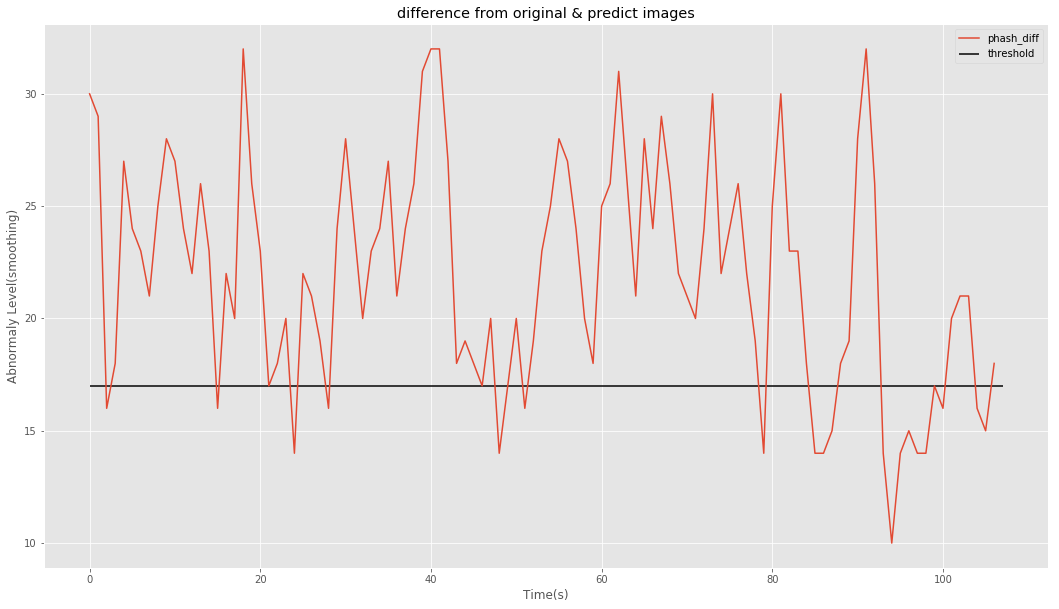

In [115]:
plt.figure(figsize=(18,10))
scores_df.phash_diff.plot()
plt.hlines(17, 0, scores_df.shape[0], label="threshold")
plt.title("difference from original & predict images")
plt.xlabel("Time(s)")
plt.ylabel("Abnormaly Level(smoothing)")
plt.legend()

In [116]:
from scipy.interpolate import spline

In [125]:
x_smooth/2

array([ 0.        ,  0.50471698,  1.00943396,  1.51415094,  2.01886792,
        2.52358491,  3.02830189,  3.53301887,  4.03773585,  4.54245283,
        5.04716981,  5.55188679,  6.05660377,  6.56132075,  7.06603774,
        7.57075472,  8.0754717 ,  8.58018868,  9.08490566,  9.58962264,
       10.09433962, 10.5990566 , 11.10377358, 11.60849057, 12.11320755,
       12.61792453, 13.12264151, 13.62735849, 14.13207547, 14.63679245,
       15.14150943, 15.64622642, 16.1509434 , 16.65566038, 17.16037736,
       17.66509434, 18.16981132, 18.6745283 , 19.17924528, 19.68396226,
       20.18867925, 20.69339623, 21.19811321, 21.70283019, 22.20754717,
       22.71226415, 23.21698113, 23.72169811, 24.22641509, 24.73113208,
       25.23584906, 25.74056604, 26.24528302, 26.75      , 27.25471698,
       27.75943396, 28.26415094, 28.76886792, 29.27358491, 29.77830189,
       30.28301887, 30.78773585, 31.29245283, 31.79716981, 32.30188679,
       32.80660377, 33.31132075, 33.81603774, 34.32075472, 34.82

In [128]:
scores_df.shape[0]

107

In [148]:
x_smooth = np.linspace(0, scores_df.shape[0]/2, scores_df.shape[0])
y_smooth = spline(range(scores_df.phash_diff.shape[0]), scores_df.phash_diff, x_smooth)

/home/nvidia/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


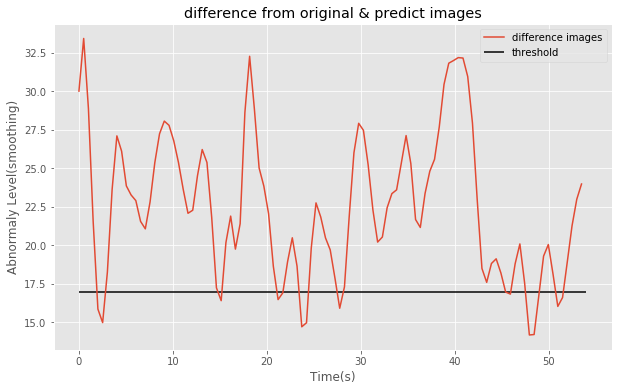

In [151]:
plt.figure(figsize=(10,6))
plt.plot(x_smooth, y_smooth, label="difference images")
plt.hlines(17, 0, scores_df.shape[0]//2 + 1, label="threshold")
plt.title("difference from original & predict images")
plt.xlabel("Time(s)")
plt.ylabel("Abnormaly Level(smoothing)")
plt.legend()

### 独自ラベルに基づくprecision recall

In [152]:
from sklearn.metrics import classification_report

In [153]:
scores_df["label"] = scores_df.phash_diff.map(lambda x: 0 if x < 17 else 1)

In [154]:
print(classification_report([1 for _ in range(scores_df.shape[0])], scores_df.label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90       107

   micro avg       0.82      0.82      0.82       107
   macro avg       0.50      0.41      0.45       107
weighted avg       1.00      0.82      0.90       107



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 動画のデータを計算してヒストグラム化する

In [16]:
np.sum(np.abs(vids[0] - vids_pred[0]), axis=0)

array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.01201337],
        ...,
        [0.01877365],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.06420634],
        [3.59790027],
        ...,
        [0.68616483],
        [0.10345615],
        [0.        ]],

       [[0.        ],
        [0.06661036],
        [2.88471179],
        ...,
        [0.48239718],
        [0.08313112],
        [0.        ]],

       [[0.        ],
        [0.09002262],
        [0.58257227],
        ...,
        [0.37551711],
        [0.10566341],
        [0.        ]]])

In [17]:
vids_diff = []
for vid_orig, vid_pred in zip(vids, vids_pred):
    l = []
    for frame_orig, frame_pred in zip(vid_orig, vid_pred):
        y_diff = frame_orig.reshape(32,32) - frame_pred.reshape(32,32)
        l.append(np.sum(np.abs(y_diff)))
    vids_diff.append(np.array(l).mean())

In [18]:
import pandas as pd

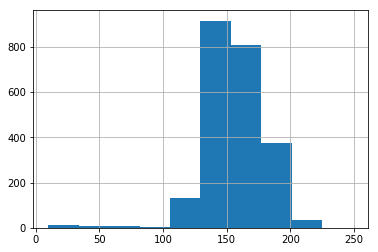

In [19]:
pd.Series(vids_diff).hist()